In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Constants

$C_0 = 0.2$</br>
$m_l = -81.1$</br>
$m_s = -478$</br>
$c_p = 820$</br>
$ρ = 7000$</br>
$L_f = 276000$</br>
$T_f = 1538$</br>
$T_∞ = 1540$</br>
$T_0 = 1510$</br>
$k_0 = 0.8$</br>
$Le = 300$</br>

$Ste = c_p(T_∞-T_0)/L_f$</br>
$θ_f = (T_f-T_0)/(T_∞-T_0)$

###Conditions

Domain $\epsilon \in [0,ϵ^*]$</br>
$C_s = k_0C_l^*$</br>
PDE1: $\frac{∂\theta_s}{∂\tau} = \frac{∂^2\theta_s}{∂\epsilon^2}$</br>
Domain $\epsilon \in [ϵ^*,1]$</br>
PDE2: $\frac{∂\theta_l}{∂\tau} = \frac{∂^2\theta_l}{∂\epsilon^2}$</br>
PDE3: $\frac{∂C_l}{∂\tau} = \frac{1}{Le}\frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface ($ϵ=ϵ^*$)</br>
PDE4: $\frac{1}{Ste}\frac{∂\epsilon^*}{∂\tau} = \frac{∂\theta_s}{∂\epsilon}-\frac{∂\theta_l}{∂\epsilon}$</br>
PDE5: $\frac{-1}{Le}\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)\frac{dϵ^*}{dτ}$</br>

5 PDEs with 5 Variables [$θ_s(x,t)$, $θ_l(x,t)$, $C_s(x,t)$, $C_l(x,t)$, $ϵ^*(t)$]</br>
Model the 5 variables using 3 neural networks and optimise the NN parameters</br>

Initial ($\tau = 0$)</br>
$θ_l=1$ ; $C_l=C_0$ ; $ϵ^*=0$</br>
Interface ($ϵ=ϵ^*$)</br>
$θ_s=θ_l=θ^*$</br>
$C_l^* = (T_0-T_∞)(θ_f-θ^*)/m_l$</br>
Left BC ($ϵ=0$)</br>
$θ_s=0$

##Code

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0, phi = 0.2*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.8*a, 0.09290632*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
import tensorflow as tf
import numpy as np
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0, phi = 0.05*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.17*a, 0.1159*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
def C_(u_):
  return (T0-Ti)*(uf-u_)/ml # concentration of liquid at interface (Cl*) given interface temp

###Evaluating PDEs

In [ ]:
def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - u2_xx

def f3(c_t, c_xx): # calculates PDE3 value given c's derivatives
  return c_t - (c_xx/Le)

def f4(s_t, u1_x, u2_x): # calculates PDE4 value
  return (s_t/Ste) - u1_x + u2_x

def f5(c_x, cstar, s_t): # calculates PDE5 value
  return (cstar*(1-k0)*s_t)+(c_x/Le)

###Analytical Solutions

In [ ]:
def u1_anal(t,x): # calculates u1 value from its analytical solution
  return ustar*tf.math.erf(x/(2*(t**0.5)))/tf.math.erf(phi)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return 1-((1-ustar)*tf.math.erfc(x/(2*(t**0.5)))/tf.math.erfc(phi))

c1_anal = k0*C_(ustar) # analytical value of Cs

def c2_anal(t,x): # calculates c2 value from its analytical solution
  return C0 + ((C_(ustar)-C0)*tf.math.erfc((x*(Le**0.5))/(2*(t**0.5)))/tf.math.erfc(phi*(Le**0.5)))

def s_anal(t): # calculates s value from its analytical solution
  return 2*phi*(t**0.5)

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

def c_anal(t,x): # analytical value of c given x and t
  return tf.where(tf.math.greater(s_anal(t),x),c1_anal,c2_anal(t,x))

###Training Data

In [ ]:
Nm1, Nm2 = 900, 50 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm1 = tf.random.uniform((Nm1,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
tm2 = tf.random.uniform((Nm2,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
im = tf.zeros(shape=(Nm2,1), dtype=DTYPE)
tm = tf.concat([tm1,tm2,im],axis=0)
xm1 = tf.random.uniform((Nm1,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
sm = s_anal(tm2)
xm2 = tf.random.uniform((Nm2,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
xm = tf.concat([xm1,sm,xm2],axis=0)
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points
sm2 = s_anal(tm)

In [ ]:
Nm1, Nm2 = 250, 25 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm1 = tf.random.uniform((Nm1,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
tm2 = tf.random.uniform((Nm2,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
im = tf.zeros(shape=(Nm2,1), dtype=DTYPE)
tm = tf.concat([tm1,tm2,im],axis=0)
xm1 = tf.random.uniform((Nm1,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
sm = s_anal(tm2)
xm2 = tf.random.uniform((Nm2,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
xm = tf.concat([xm1,sm,xm2],axis=0)
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points
sm2 = s_anal(tm)

In [ ]:
Nm = 200 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm = tf.random.uniform((Nm,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xm = tf.random.uniform((Nm,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points

###Modelling Variables

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c2_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for Cl
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100): # n_hidden layers each with n_neurons and swish activation + residual connection from 2 encoders
  inputs = tf.keras.Input(2) # Input Layer for x and t
  u = tf.keras.layers.Dense(1, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal')(inputs) # encoder 1
  v = tf.keras.layers.Dense(1, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal')(inputs) # encoder 2
  h = tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal')(inputs)
  for i in range(n_hidden-1):
    z = tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal')(h)
    h = tf.keras.layers.Multiply()([1-z,u]) + tf.keras.layers.Multiply()([z,v])
  outputs = tf.keras.layers.Dense(2)(h) # Output Layer for u1 and u2
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for c1 and c2
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

In [ ]:
def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for c1 and c2
  return model

###Compute gradients to return PDE values

In [ ]:
def get_f(umodel, smodel, c2model, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    c2 = c2model(tf.concat([t, x], axis=1)) # c2 as a function of t and x
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    cb = c2model(tf.concat([t, s], axis=1))
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

In [ ]:
def get_f(umodel, smodel, cmodel, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    c = cmodel(tf.concat([t, x], axis=1)) # c1 and c2 as functions of t and x
    c1, c2 = c[:, 0:1], c[:, 1:2]
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    cb = cmodel(tf.concat([t, s], axis=1))[:, 1:2]
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

###Calculating loss

In [ ]:
def loss_fxn(umodel, smodel, c1, cmodel, mea, um, cm, coll): # compute Loss given model and data

  tc = coll[:,0:1]
  psb = smodel(tc) # Predicted Interface positions
  pub = umodel(tf.concat([tc, psb], axis=1)) # Interface Temperature prediction
  pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
  pcb = cmodel(tf.concat([tc, psb], axis=1)) # Interface Concentration prediction
  xi = tf.zeros(shape=tf.shape(tc), dtype=DTYPE)
  pu0b = umodel(tf.concat([tc, xi], axis=1))[:, 0:1] # Left boundary temperature prediction
  Lb1 = tf.reduce_mean(tf.square(pu0b))
  Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
  Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))

  pc1 = tf.ones_like(tc,dtype=DTYPE)
  Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb)))

  init = tf.constant(0,shape=(1,1))
  init2 = tf.concat([xi, coll[:,1:2]], axis=1)
  pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
  pc2i = cmodel(init2) # predicted initial conc of liquid
  Li1 = tf.squeeze(tf.square(smodel(init)))
  Li2 = tf.reduce_mean(tf.square(pc2i-C0))
  Li3 = tf.reduce_mean(tf.square(pu2i-a))

  pum = umodel(mea) # Temperature prediction on measurement data
  pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
  pc2m = cmodel(mea) # Liquid Concentration prediction on measurement data
  pc1m = tf.ones_like(pc2m, dtype=DTYPE)*c1 # Solid Concentration prediction on measurement data
  psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
  pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
  pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
  Lm1 = tf.reduce_mean(tf.square(um - pum))
  Lm2 = tf.reduce_mean(tf.square(cm - pcm))
  Lm3 = tf.reduce_mean(tf.square(sm2 - psm))

  f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
  Lc1 = tf.reduce_mean(tf.square(f_1))
  Lc2 = tf.reduce_mean(tf.square(f_2))
  Lc3 = tf.reduce_mean(tf.square(f_3))
  Lc4 = tf.reduce_mean(tf.square(f_4))
  Lc5 = tf.reduce_mean(tf.square(f_5))

  losses = [Lb1*256,Lb2*256,Lb3*256,Ls,Li1*25600,Li2*100,Li3*100,Lc1,Lc2,Lc3,Lc4,Lc5,Lm1*25.6,Lm2*25.6,Lm3*25.6]

  return losses

In [ ]:
def loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll): # compute Loss given model and data

  tc = coll[:,0:1]
  psb = smodel(tc) # Predicted Interface positions
  pub = umodel(tf.concat([tc, psb], axis=1)) # Interface Temperature prediction
  pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
  pcb = cmodel(tf.concat([tc, psb], axis=1))[:, 1:2] # Interface Concentration prediction
  xi = tf.zeros(shape=tf.shape(tc), dtype=DTYPE)
  pu0b = umodel(tf.concat([tc, xi], axis=1))[:, 0:1] # Left boundary temperature prediction
  Lb1 = tf.reduce_mean(tf.square(pu0b))
  Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
  Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))

  pc1 = cmodel(coll)[:,0:1]
  Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb)))

  init = tf.constant(0,shape=(1,1))
  init2 = tf.concat([xi, coll[:,1:2]], axis=1)
  pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
  pc2i = cmodel(init2)[:, 1:2] # predicted initial conc of liquid
  Li1 = tf.squeeze(tf.square(smodel(init)))
  Li2 = tf.reduce_mean(tf.square(pc2i-C0))
  Li3 = tf.reduce_mean(tf.square(pu2i-a))

  pum = umodel(mea) # Temperature prediction on measurement data
  pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
  pcm = cmodel(mea) # Concentration prediction on measurement data
  pc1m, pc2m =  pcm[:, 0:1], pcm[:, 1:2]
  psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
  pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
  pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
  Lm1 = tf.reduce_mean(tf.square(um - pum))
  Lm2 = tf.reduce_mean(tf.square(cm - pcm))

  f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
  Lc1 = tf.reduce_mean(tf.square(f_1))
  Lc2 = tf.reduce_mean(tf.square(f_2))
  Lc3 = tf.reduce_mean(tf.square(f_3))
  Lc4 = tf.reduce_mean(tf.square(f_4))
  Lc5 = tf.reduce_mean(tf.square(f_5))

  losses = [Lb1*256,Lb2*256,Lb3*256,Ls,Li1*25600,Li2*100,Li3*100,Lc1,Lc2,Lc3,Lc4,Lc5,Lm1*85.33,Lm2*85.33]

  return losses

###Computing Loss Gradients

In [ ]:
def L_and_grad_Lw(umodel, smodel, c1, cmodel, mea, um, cm, coll, lamb1, lamb2): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn(umodel, smodel, c1, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lur = losses[7] + losses[8]
    Lcr = losses[9] + losses[3]
    Lud = losses[-3]
    Lcd = losses[-2]
    loss = sum(losses[2:12]) + lamb1*Lud + lamb2*Lcd
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gu, gs, gc, gur, gud, gcr, gcd

In [ ]:
def L_and_grad_Lw(umodel, smodel, c1, cmodel, mea, um, cm, coll, lamb2): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn(umodel, smodel, c1, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lcr = losses[9] + losses[11]
    Lcd = losses[-2] + losses[2] +losses[3] + losses[5]
    loss = sum(losses[2:12]) + lamb2*Lcd
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gc, gcr, gcd

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, mea, um, cm, coll, lamb1, lamb2): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lur = losses[7] + losses[8]
    Lcr = losses[9] + losses[3]
    Lud = losses[-2]
    Lcd = losses[-1]
    loss = sum(losses[2:12]) + lamb1*Lud + lamb2*Lcd
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gu, gs, gc, gur, gud, gcr, gcd

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, mea, um, cm, coll, lamb2): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lcr = losses[9] + losses[3]
    Lcd = losses[-1]
    loss = sum(losses[2:12]) + lamb2*Lcd
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gc, gcr, gcd

In [ ]:
Nc = 10000 # No of collocation points
umodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/u3model') # initialise the Temp NN model
smodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/s3model') # initialise the Intf NN model
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/c3model') # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1500,3500],[1e-2,5e-3,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.00005) # Adam Optimiser

In [ ]:
Nc = 10000 # No of collocation points
umodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/pinn_umodel_ct5') # initialise the Temp NN model
smodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/pinn_smodel_ct5') # initialise the Intf NN model
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/pinn_cmodel_ct5') # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1500,3500],[1e-2,5e-3,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # Adam Optimiser

In [ ]:
Nc = 10000 # No of collocation points
umodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/UMCT8') # initialise the Temp NN model
smodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/SMCT8') # initialise the Intf NN model
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/CMCT8') # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1500,3500],[1e-2,5e-3,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # Adam Optimiser

In [ ]:
Nc = 10000 # No of collocation points
umodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/UMCT9') # initialise the Temp NN model
smodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/SMCT9') # initialise the Intf NN model
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/CMCT9') # initialise the Conc NN model
c1 = 0.194
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1500,3500],[1e-2,5e-3,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # Adam Optimiser

In [ ]:
@tf.function
def train_step(coll,lamb1,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gu, gs, gc, gur, gud, gcr, gcd = L_and_grad_Lw(umodel, smodel, c1, cmodel, meas, um, cm, coll, lamb1, lamb2)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return losses, new_lamb1, new_lamb2

In [ ]:
def train_step(coll,lamb1,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gu, gs, gc, gur, gud, gcr, gcd = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, coll, lamb1, lamb2)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  #optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return losses, new_lamb1, new_lamb2

In [ ]:
def train_step(coll,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gc, gcr, gcd = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, coll, lamb2)
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return losses, new_lamb2

In [ ]:
@tf.function
def train_step(coll,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gc, gcr, gcd = L_and_grad_Lw(umodel, smodel, c1, cmodel, meas, um, cm, coll, lamb2)
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return losses, new_lamb2

In [ ]:
@tf.function
def train_step(coll,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gc, gcr, gcd = L_and_grad_Lw(umodel, smodel, c1, c2model, meas, um, cm, coll, lamb2)
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc, c2model.trainable_variables))
  return losses, new_lamb2

In [ ]:
uweights, cweights = [], []
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
  uweights.append(umodel.get_weights())
  cweights.append(cmodel.get_weights())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[1.2540731, 0.7834587, 0.7266049, 0.705144, 3.801895e-06, 0.00017296353, 0.004788231, 0.053680055, 0.094275765, 4.3420943e-08, 0.4249038, 8.886028e-06, 0.03045151, 0.0037745999, 0.0015143128]
[0.6370805, 0.7890559, 0.27093592, 0.6824725, 3.801895e-06, 0.0016534565, 0.14276311, 0.075229764, 0.10168387, 8.251936e-06, 0.31254083, 9.207088e-06, 0.01824897, 0.0026046976, 0.0015143128]
[0.67653644, 0.5788428, 0.24364148, 0.6823489, 3.801895e-06, 0.0012163424, 0.112098105, 0.091838524, 0.14761956, 1.0058263e-05, 0.30997193, 9.263682e-06, 0.015261918, 0.0025875112, 0.0015143128]
[0.692122, 0.45563358, 0.24337646, 0.6821485, 3.801895e-06, 0.0012888933, 0.09238291, 0.09880419, 0.18181026, 1.1315948e-05, 0.31010187, 9.23333e-06, 0.013545269, 0.0025647562, 0.0015143128]
[0.5713478, 0.34403655, 0.2346705, 0.68169576, 3.801895e-06, 0.0014523363, 0.08454417, 0.10482042, 0.20328234, 1.30742665e-05, 0.29214457, 9.099139e-06, 0.012541942, 0.002539238, 0.0015143128]
[0.46622896, 0.27557, 0.21667324, 0.68

Text(0, 0.5, 'Loss')

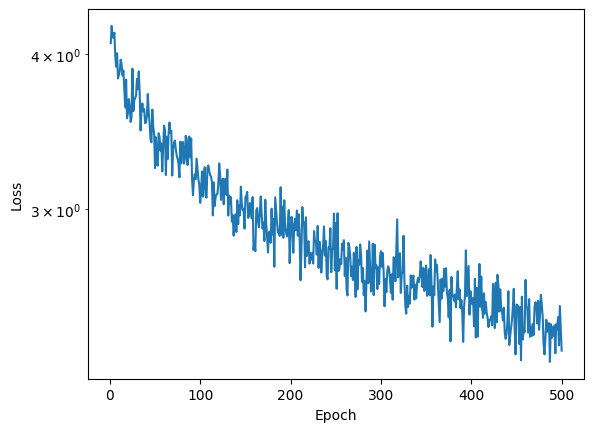

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

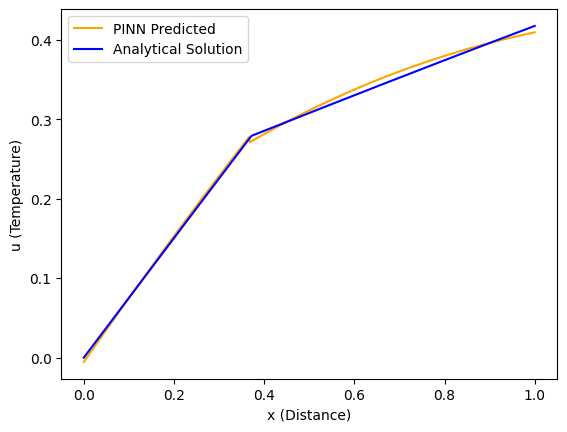

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*4
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

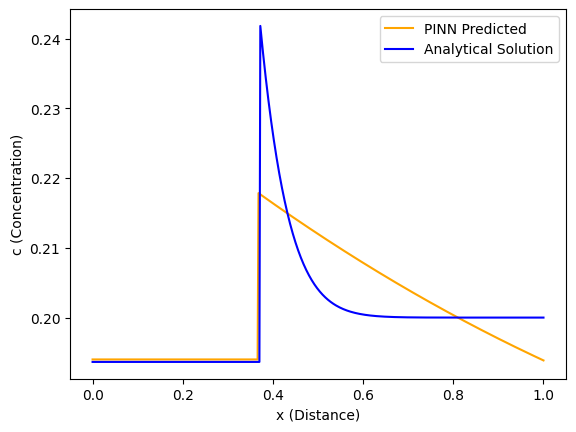

In [ ]:
c2p = cmodel(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

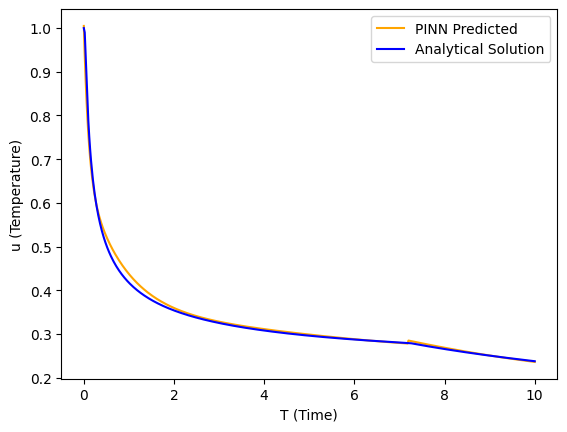

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

In [ ]:
cmodel.save('/content/drive/MyDrive/Shivprasad/c2m')

In [ ]:
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/c2m')

Text(0, 0.5, 'c (Concentration)')

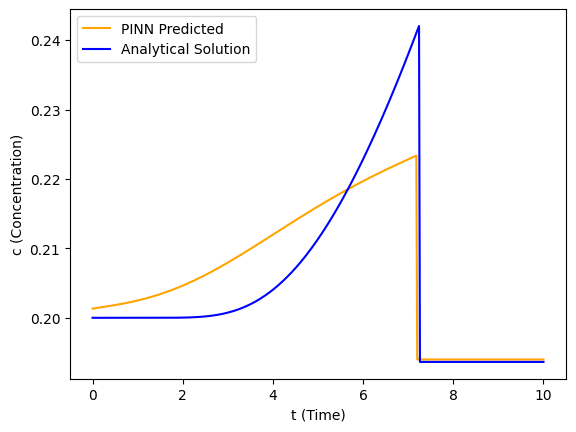

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
C1 = tf.ones_like(cpred,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), C1, cpred)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

In [ ]:
def get_f(smodel, c2model, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    c2 = c2model(tf.concat([t, x], axis=1)) # c2 as a function of t and x
    s = smodel(t)
    tape.watch(s)
    cb = c2model(tf.concat([t, s], axis=1))
    # defined within context to compute 2nd derivatives
    c_x = tape.gradient(c2, x)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f3(c_t, c_xx), f5(cb_x, cb, s_t)

In [ ]:
def loss_fxn(umodel, smodel, c1, c2model, mea, um, cm, xc, times, e): # compute loss given model and data

    pc2m = c2model(mea) # Liquid concentration prediction on measurement data
    pc1m = tf.ones_like(pc2m, dtype=DTYPE)*c1
    psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
    pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
    Lm = tf.reduce_mean(tf.square(cm - pcm))

    init = tf.constant(0,shape=(1,1),dtype=DTYPE)
    ti = tf.zeros(shape=xc.shape, dtype=DTYPE)
    init2 = tf.concat([ti, xc], axis=1)
    pc2i = c2model(init2) # predicted initial conc of liquid
    Li = tf.reduce_mean(tf.square(pc2i-C0))

    tot_loss = Lm*25.6 + Li*100
    sum_loss = tf.zeros(shape=(), dtype=DTYPE)
    error = Lm+Li

    for t in times:

      ts = tf.reshape(t,(1,1))
      psb = smodel(ts) # Predicted Interface position
      pub = umodel(tf.concat([ts, psb], axis=1)) # Interface Temperature prediction
      pu1b = pub[:, 0:1]
      pcb = c2model(tf.concat([ts, psb], axis=1)) # Liquid Interface Concentration prediction
      Lb = tf.reduce_mean(tf.square(pcb-C_(pu1b)))
      Ls = tf.reduce_mean(tf.square(c1-(k0*pcb))) # relation bwn Cs and Cl*

      tc = tf.ones_like(xc, dtype=DTYPE)*t
      coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
      f_3, f_5 = get_f(smodel, c2model, coll) # calculate f values given models and collocation data
      Lc3 = tf.reduce_mean(tf.square(f_3))
      Lc5 = tf.reduce_mean(tf.square(f_5))
      Lc = Lc3 + Lc5

      w = tf.math.exp(-e*sum_loss)
      tot_loss += w*(Lc+Lb*256+Ls*256)/Nt
      sum_loss += (Lc+Lb*256+Ls*256)
      error += (Lb+Lc+Ls)/Nt

    return tot_loss, error

In [ ]:
def L_and_grad_Lw(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss, error = loss_fxn(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e) # loss as a function of model (& hence weights)
  gc2 = tape.gradient(loss, cmodel.trainable_variables)
  del tape
  return loss, error, gc2

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)

In [ ]:
@tf.function
def train_step(xc, times, e):
  # compute loss and its gradient wrt model parameters
  loss, error, gc2 = L_and_grad_Lw(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc2, cmodel.trainable_variables))
  return loss, error

In [ ]:
cweights = []

from time import time
N = 200 # no of epochs or training iterations
losses = []
errors = []
t0 = time()
epsilons = [0.01,0.1,1,10,100]

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        l, e = train_step(xc, times, e)
        loss = l.numpy()
        error = e.numpy()
        losses.append(loss)
        errors.append(error)
        cweights.append(cmodel.get_weights())
        if i%5==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss)+' and Error = '+str(error))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 0.01 ...
   Epoch = 5 --> Loss = 2.2389283 and Error = 0.033227023
   Epoch = 10 --> Loss = 0.43172807 and Error = 0.0024263328
   Epoch = 15 --> Loss = 0.10446683 and Error = 0.0013292409
   Epoch = 20 --> Loss = 0.16198033 and Error = 0.0016070907
   Epoch = 25 --> Loss = 0.05110198 and Error = 0.0008842764
   Epoch = 30 --> Loss = 0.102623716 and Error = 0.0008359777
   Epoch = 35 --> Loss = 0.06653833 and Error = 0.0008370803
   Epoch = 40 --> Loss = 0.056850802 and Error = 0.0008954669
   Epoch = 45 --> Loss = 0.06540071 and Error = 0.0009865954
   Epoch = 50 --> Loss = 0.07221061 and Error = 0.0009919545
   Epoch = 55 --> Loss = 0.049547024 and Error = 0.000794809
   Epoch = 60 --> Loss = 0.05305886 and Error = 0.00084142503
   Epoch = 65 --> Loss = 0.061694033 and Error = 0.0007619534
   Epoch = 70 --> Loss = 0.045641284 and Error = 0.00074806454
   Epoch = 75 --> Loss = 0.05761862 and Error = 0.0008830581
   Epoch = 80 --> Loss = 0.10714014 and Error = 0.0

In [ ]:
losses.index(min(losses)),errors.index(min(errors))

(800, 922)

In [ ]:
losses[800], errors[800]

(0.0045972266, 0.0005847791)

In [ ]:
losses[922], errors[922]

(0.005355993, 0.00020630061)

Text(0, 0.5, 'Loss')

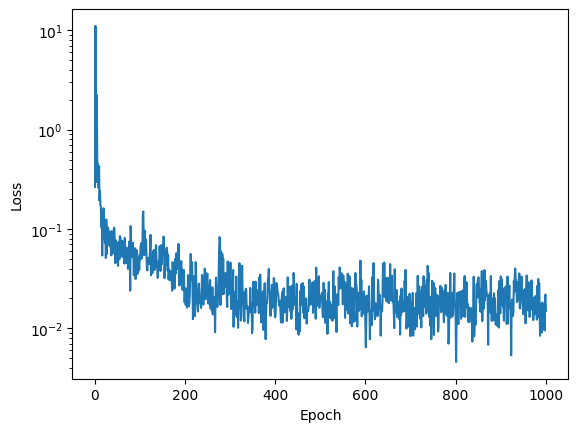

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,1001)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
c2model = c2_model()
c2model.set_weights(cweights[922])

Text(0, 0.5, 'c (Concentration)')

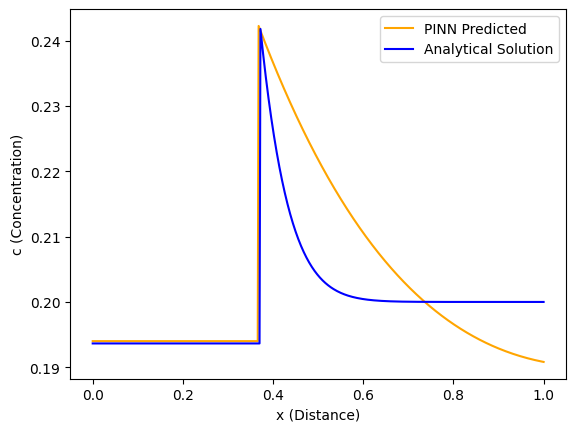

In [ ]:
c2p = cmodel(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'c (Concentration)')

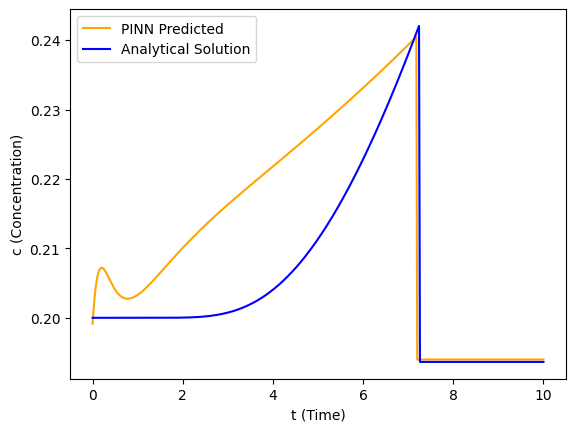

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
C1 = tf.ones_like(cpred,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), C1, cpred)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

In [ ]:
c2model.save('/content/drive/MyDrive/Shivprasad/c2m2')

Text(0, 0.5, 'c (Concentration)')

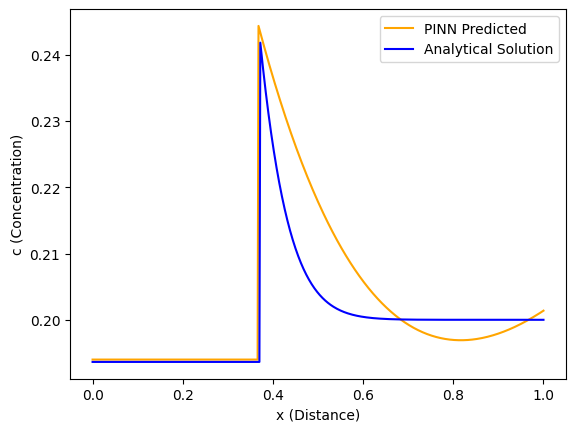

In [ ]:
c2p = c2model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'c (Concentration)')

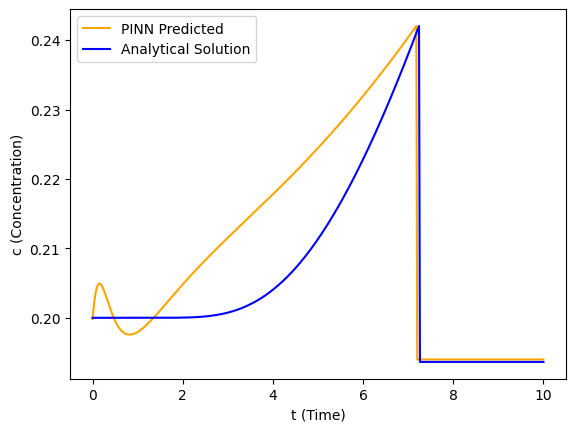

In [ ]:
cpred = c2model(tf.concat([T, X], axis=1))
C1 = tf.ones_like(cpred,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), C1, cpred)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

In [ ]:
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb2 = 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb2 = train_step(coll,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.478206, 0.2775954, 0.21139827, 0.6811277, 3.801895e-06, 0.0015595669, 0.07152939, 0.09810549, 0.1940967, 1.4293507e-05, 0.2791485, 9.174338e-06, 0.011790904, 0.0025141684, 0.0015143128]
[0.56923205, 0.3162565, 0.051903993, 0.6524782, 3.801895e-06, 0.018029038, 0.070945635, 0.10313214, 0.21077344, 2.8464556e-05, 0.27556762, 1.0797642e-05, 0.011790904, 0.008755269, 0.0015143128]
[0.50505656, 0.2886759, 0.054541565, 0.651969, 3.801895e-06, 0.018185973, 0.07125045, 0.09668102, 0.19254549, 2.988064e-05, 0.28252614, 1.1050485e-05, 0.011790904, 0.008916152, 0.0015143128]
[0.56850463, 0.30769706, 0.054858997, 0.6515122, 3.801895e-06, 0.018033063, 0.071672276, 0.10998423, 0.22272915, 3.0297519e-05, 0.27509686, 1.0889719e-05, 0.011790904, 0.009049832, 0.0015143128]
[0.4974948, 0.28052858, 0.050810993, 0.6509935, 3.801895e-06, 0.018205997, 0.072063826, 0.10669076, 0.21623445, 3.0473948e-05, 0.2640358, 1.0583645e-05, 0.011790904, 0.009157705, 0.0015143128]
[0.44739687, 0.26347318, 0.052403137, 

Text(0, 0.5, 'Loss')

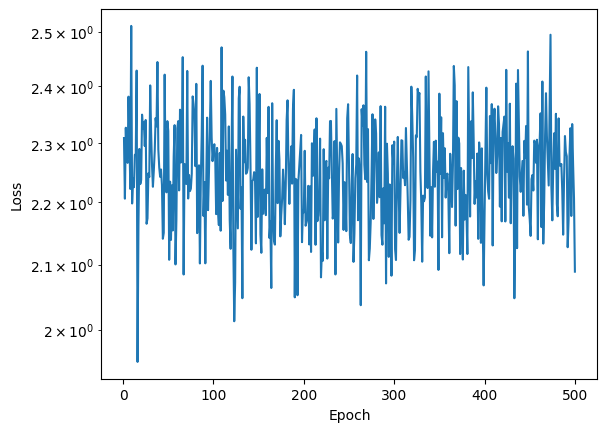

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'c (Concentration)')

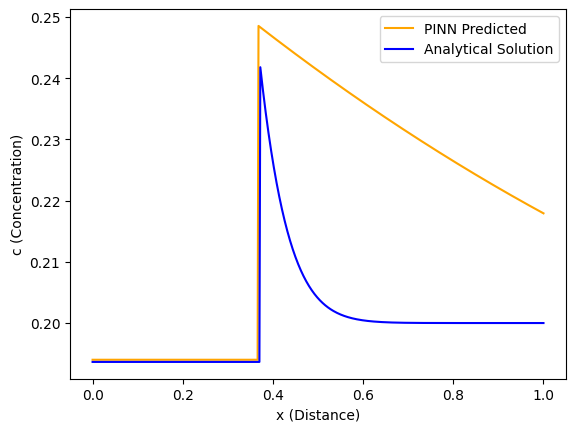

In [ ]:
c2p = cmodel(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'c (Concentration)')

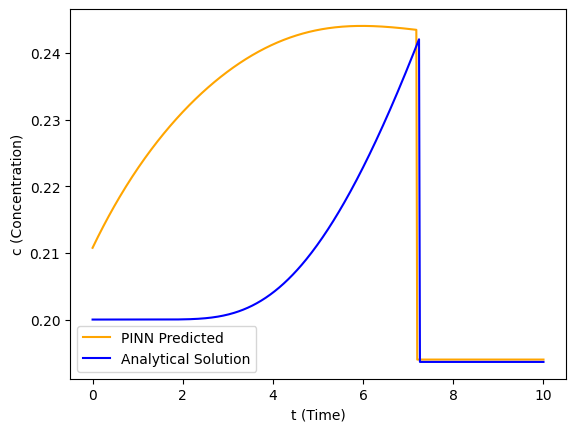

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
C1 = tf.ones_like(cpred,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), C1, cpred)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

In [ ]:
# learning_rate = 0.00005 and new:old coeff = 0.1:0.9
uweights, cweights = [], []
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
  uweights.append(umodel.get_weights())
  cweights.append(cmodel.get_weights())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.73157674, 0.36687714, 3.315871, 0.00031352128, 0.0002568206, 0.00040156042, 0.0002554597, 0.30024937, 0.3290368, 0.0002612125, 0.47616065, 5.017281e-05, 0.014751251, 0.023420118]
[0.46904552, 0.43550342, 1.2254531, 3.83865e-05, 0.0002568206, 0.008142635, 0.042125866, 0.41135845, 0.5256106, 0.00064842997, 0.3466561, 0.000108224085, 0.0076591633, 0.04105789]
[0.36917242, 0.4145271, 0.46331987, 7.181415e-05, 0.0002568206, 0.053213794, 0.03791752, 0.31724462, 0.48579288, 0.0012511814, 0.30413, 0.00019495944, 0.0067664534, 0.0677339]
[0.31313682, 0.39789498, 0.3788852, 8.7618704e-05, 0.0002568206, 0.061150774, 0.040550128, 0.3398711, 0.60910404, 0.001619846, 0.29154086, 0.00021594315, 0.006029541, 0.06397714]
[0.20915273, 0.33536774, 0.36109897, 5.6297467e-05, 0.0002568206, 0.07081291, 0.04316656, 0.3992403, 0.86323196, 0.0013955202, 0.2820138, 0.00019644205, 0.005457564, 0.05854966]
[0.18247321, 0.31469506, 0.36079425, 4.517482e-05, 0.0002568206, 0.08502474, 0.046914153, 0.5861807, 1.63

Text(0, 0.5, 'Loss')

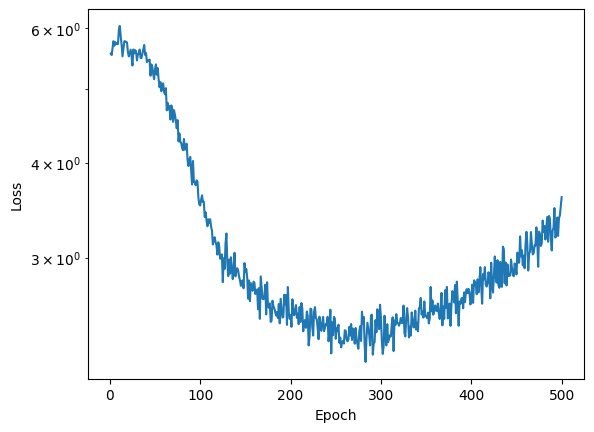

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
losses[260:290]

[2.4075162,
 2.34535,
 2.3315396,
 2.3441157,
 2.4361646,
 2.3729699,
 2.4564419,
 2.3406072,
 2.4232678,
 2.3979278,
 2.314665,
 2.4268646,
 2.3472955,
 2.3106632,
 2.2799563,
 2.398462,
 2.4399097,
 2.3335166,
 2.5489023,
 2.4600873,
 2.509887,
 2.304203,
 2.1907525,
 2.3504624,
 2.4662604,
 2.4222305,
 2.3804104,
 2.3027804,
 2.5209043,
 2.5270588]

In [ ]:
losses[282]

2.1907525

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for c1 and c2
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

In [ ]:
u3model = u_model()
u3model.set_weights(uweights[282])
c3model = c_model()
c3model.set_weights(cweights[282])

Text(0, 0.5, 'u (Temperature)')

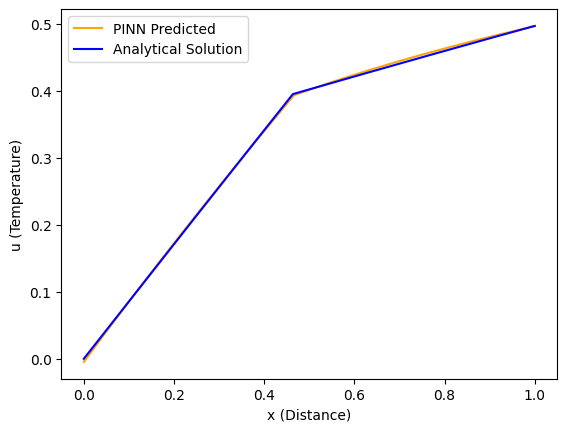

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*4
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u3model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

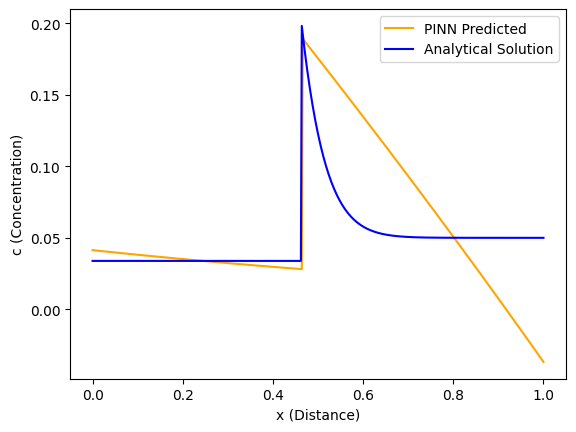

In [ ]:
cpred = c3model(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

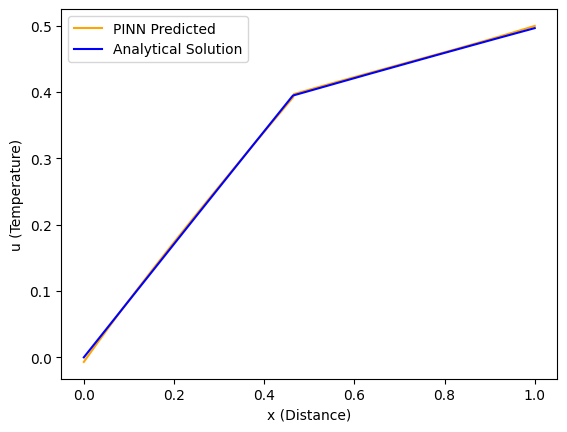

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*4
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

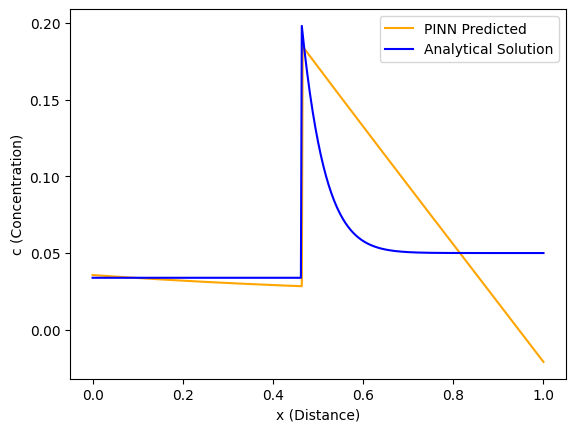

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
def get_f(umodel, smodel, cmodel, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    c = cmodel(tf.concat([t, x], axis=1)) # c1 and c2 as functions of t and x
    c1, c2 = c[:, 0:1], c[:, 1:2]
    s = smodel(t)
    tape.watch(s)
    cb = cmodel(tf.concat([t, s], axis=1))[:, 1:2]
    # defined within context to compute 2nd derivatives
    c_x = tape.gradient(c2, x)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f3(c_t, c_xx), f5(cb_x, cb, s_t)

In [ ]:
def loss_fxn(umodel, smodel, cmodel, mea, um, cm, xc, times, e): # compute loss given model and data

    pcm = cmodel(mea) # Concentration prediction on measurement data
    pc1m, pc2m =  pcm[:, 0:1], pcm[:, 1:2]
    psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
    pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
    #Lm1 = tf.reduce_mean(tf.square(um - pum))
    Lm = tf.reduce_mean(tf.square(cm - pcm))*85.33
    #Lm3 = tf.reduce_mean(tf.square(sm2 - psm))
    #Lm = (Lm1 + Lm2 + Lm3)*85.33

    init = tf.constant(0,shape=(1,1),dtype=DTYPE)
    ti = tf.zeros(shape=xc.shape, dtype=DTYPE)
    init2 = tf.concat([ti, xc], axis=1)
    pc2i = cmodel(init2)[:, 1:2] # predicted initial conc of liquid
    #Li1 = tf.squeeze(tf.square(smodel(init)))
    Li = tf.reduce_mean(tf.square(pc2i-C0))*100
    #Li3 = tf.reduce_mean(tf.square(pu2i-a))
    #Li = Li1*25600 + Li2*100 + Li3*100

    tot_loss = Lm + Li
    sum_loss = tf.zeros(shape=(), dtype=DTYPE)

    for t in times:

      ts = tf.reshape(t,(1,1))
      psb = smodel(ts) # Predicted Interface position
      pub = umodel(tf.concat([ts, psb], axis=1)) # Interface Temperature prediction
      pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
      pcb = cmodel(tf.concat([ts, psb], axis=1))[:, 1:2] # Interface Concentration prediction
      Lb = tf.reduce_mean(tf.square(pcb-C_(pu1b)))*256
      #Lb = (Lb1 + Lb2 + Lb3)*256

      tc = tf.constant(t,shape=xc.shape)
      coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
      f_3, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
      Lc3 = tf.reduce_mean(tf.square(f_3))
      Lc5 = tf.reduce_mean(tf.square(f_5))
      pc1 = cmodel(coll)[:,0:1]
      Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb))) # relation bwn Cs and Cl*
      Lc = Lc3 + Lc5 + Ls

      w = tf.math.exp(-e*sum_loss)
      tot_loss += w*(Lc+Lb)/Nt
      sum_loss += (Lc+Lb)

    return tot_loss

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, xc, times, e): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss = loss_fxn(umodel, smodel, cmodel, meas, um, cm, xc, times, e) # loss as a function of model (& hence weights)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  del tape
  return loss, gc

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

def train_step(xc, times, e):
  # compute loss and its gradient wrt model parameters
  loss, gc = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, xc, times, e)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return loss

In [ ]:
cweights = []

from time import time
N = 100 # no of epochs or training iterations
losses = []
t0 = time()
epsilons = [1]

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        loss = train_step(xc, times, e).numpy()
        losses.append(loss)
        cweights.append(cmodel.get_weights())
        if i%5==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 1 ...
   Epoch = 5 --> Loss = 0.036381215
   Epoch = 10 --> Loss = 0.03992912
   Epoch = 15 --> Loss = 0.04041493
   Epoch = 20 --> Loss = 0.03238561
   Epoch = 25 --> Loss = 0.016445298
   Epoch = 30 --> Loss = 0.01793663
   Epoch = 35 --> Loss = 0.014766431
   Epoch = 40 --> Loss = 0.013884958
   Epoch = 45 --> Loss = 0.013028968
   Epoch = 50 --> Loss = 0.014582594
   Epoch = 55 --> Loss = 0.01571856
   Epoch = 60 --> Loss = 0.022591254
   Epoch = 65 --> Loss = 0.017936086
   Epoch = 70 --> Loss = 0.013226024
   Epoch = 75 --> Loss = 0.11014519
   Epoch = 80 --> Loss = 0.01716447
   Epoch = 85 --> Loss = 0.027427884
   Epoch = 90 --> Loss = 0.017327106
   Epoch = 95 --> Loss = 0.017179914
   Epoch = 100 --> Loss = 0.026179308
Final Loss = 0.026179308
Computation Time = 55.57106790145238 minutes


In [ ]:
min(losses)

0.012524599

In [ ]:
losses.index(min(losses))

68

In [ ]:
c2model = c_model()
c2model.set_weights(cweights[68])

Text(0, 0.5, 'c (Concentration)')

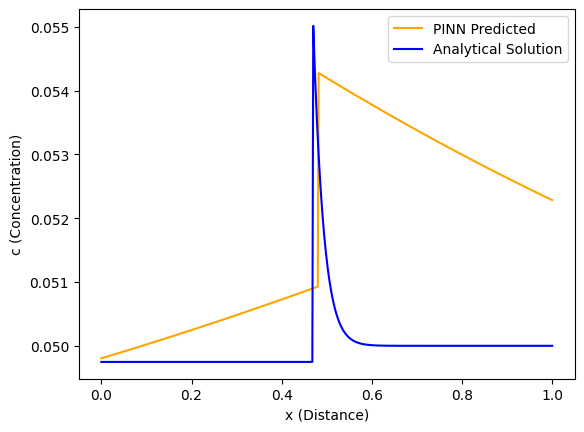

In [ ]:
cpred = c2model(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
def train_step(xc, times, e):
  # compute loss and its gradient wrt model parameters
  loss, gc = L_and_grad_Lw(umodel, smodel, c2model, meas, um, cm, xc, times, e)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gc, c2model.trainable_variables))
  return loss

In [ ]:
c2weights = []

N = 100 # no of epochs or training iterations
losses2 = []
t0 = time()

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        loss = train_step(xc, times, e).numpy()
        losses2.append(loss)
        c2weights.append(c2model.get_weights())
        if i%5==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 1 ...
   Epoch = 5 --> Loss = 0.015731016
   Epoch = 10 --> Loss = 0.014546189
   Epoch = 15 --> Loss = 0.074656375
   Epoch = 20 --> Loss = 0.015901709
   Epoch = 25 --> Loss = 0.039740138
   Epoch = 30 --> Loss = 0.025446627
   Epoch = 35 --> Loss = 0.016459709
   Epoch = 40 --> Loss = 0.018267142
   Epoch = 45 --> Loss = 0.015232818
   Epoch = 50 --> Loss = 0.024597485
   Epoch = 55 --> Loss = 0.016515091
   Epoch = 60 --> Loss = 0.021219451
   Epoch = 65 --> Loss = 0.033346873
   Epoch = 70 --> Loss = 0.0337818
   Epoch = 75 --> Loss = 0.01783759
   Epoch = 80 --> Loss = 0.020912895
   Epoch = 85 --> Loss = 0.01432357
   Epoch = 90 --> Loss = 0.030728191
   Epoch = 95 --> Loss = 0.014528708
   Epoch = 100 --> Loss = 0.015932105
Final Loss = 0.026179308
Computation Time = 61.79227411349614 minutes


In [ ]:
# learning_rate = 0.0001 and new:old coeff = 0.1:0.9
from time import time
N = 300 # no of epochs or training iterations
losses = []
t0 = time()
lamb2 = 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb2 = train_step(coll,lamb2)
  if i%50 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 50 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.18822894, 1.790391, 0.27258012, 1.7652259e-05, 0.0012957649, 6.0514976e-05, 0.05744409, 0.2394602, 5.773552, 5.5322266e-07, 0.7064842, 5.6432884e-07, 0.009041183, 0.00013536405]
[0.19515124, 1.8576528, 0.27411544, 1.9075896e-05, 0.0012957649, 6.0544273e-05, 0.056408565, 0.23177287, 5.669048, 6.1279854e-07, 0.6889945, 5.5504444e-07, 0.009041183, 0.00013346618]
[0.18255681, 1.7323803, 0.2602356, 1.923845e-05, 0.0012957649, 7.030618e-05, 0.059101358, 0.22906479, 5.872675, 6.292969e-07, 0.67303103, 5.506461e-07, 0.009041183, 0.00013141368]
[0.19776087, 1.8828602, 0.28416234, 1.9917352e-05, 0.0012957649, 4.654725e-05, 0.055937957, 0.23897111, 5.7826405, 6.4937143e-07, 0.7232322, 5.672916e-07, 0.009041183, 0.00012786587]
[0.17823777, 1.6893525, 0.26131585, 2.1168065e-05, 0.0012957649, 5.3537686e-05, 0.05930708, 0.23278269, 5.8002186, 7.830629e-07, 0.6931945, 5.576906e-07, 0.009041183, 0.00012369675]
[0.20268972, 1.9438508, 0.29527128, 2.1880925e-05, 0.0012957649, 6.191602e-05, 0.055394277

Text(0, 0.5, 'c (Concentration)')

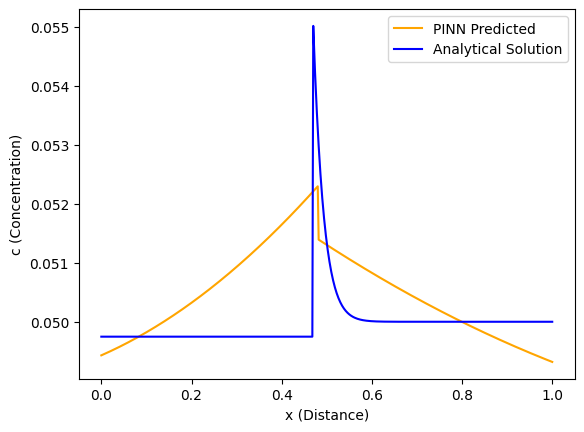

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
# learning_rate = 0.0001 and new:old coeff = 0.1:0.9
from time import time
N = 300 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%50 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 50 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.63278294, 2.5419035, 0.2807352, 3.948067e-06, 0.0012957649, 0.00038232788, 0.0030422308, 0.15558016, 0.76250607, 2.7423002e-07, 0.8716164, 6.0382246e-07, 0.023855716, 0.0003389468]
[0.39121497, 2.355777, 0.29149196, 1.2882087e-05, 0.0012957649, 8.10379e-05, 0.03955763, 0.17797887, 1.3384494, 3.9976928e-07, 0.80231464, 5.358601e-07, 0.016993314, 0.00015102419]
[0.33783445, 2.1997528, 0.29185057, 1.4192848e-05, 0.0012957649, 6.548855e-05, 0.038166933, 0.17729768, 1.7611666, 4.3317317e-07, 0.79895777, 5.520561e-07, 0.014378638, 0.00014789151]
[0.31316584, 2.2931185, 0.30248484, 1.41867995e-05, 0.0012957649, 5.8856112e-05, 0.038820446, 0.17129797, 2.2346685, 4.5863493e-07, 0.7729959, 5.5511657e-07, 0.012709847, 0.00014683537]
[0.25814652, 2.0539258, 0.28415024, 1.6746502e-05, 0.0012957649, 5.9095204e-05, 0.04240119, 0.18467844, 3.0915124, 4.8045626e-07, 0.7308882, 5.5713724e-07, 0.0113446, 0.0001431461]
[0.2393974, 2.100787, 0.30110708, 1.651401e-05, 0.0012957649, 5.8591177e-05, 0.04732

Text(0, 0.5, 'Loss')

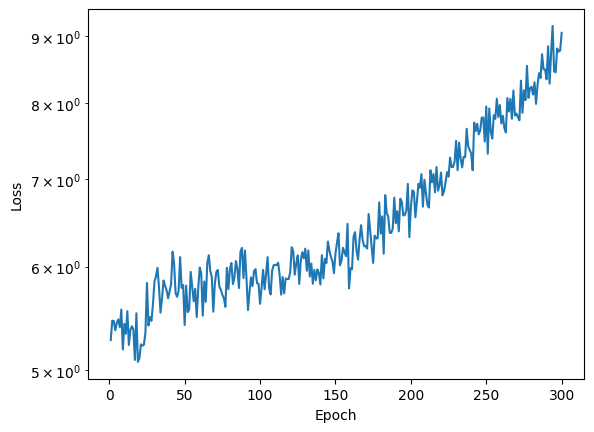

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

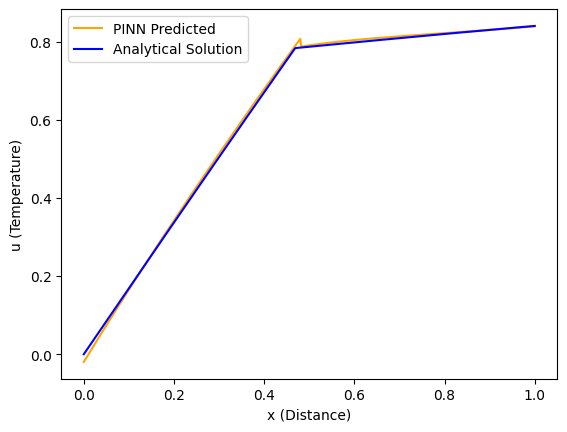

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

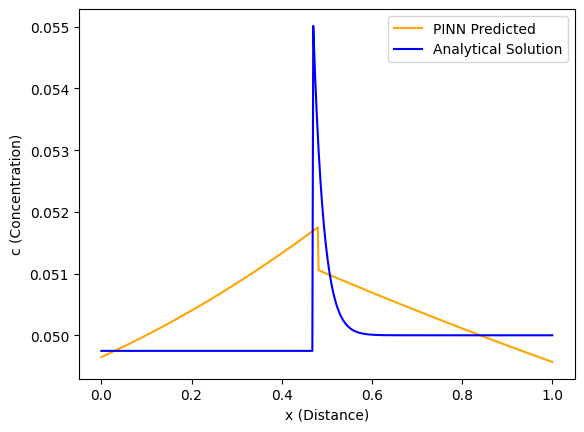

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
# learning_rate = 0.0001 and new:old coeff = 0.1:0.9
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.77276284, 0.3658629, 3.272027, 0.00031735306, 0.0002568206, 0.00039967135, 0.0002563229, 0.28761992, 0.31252044, 0.000263756, 0.4697726, 4.9716415e-05, 0.014751251, 0.023420118]
[0.4111357, 0.40833005, 0.6010835, 2.0490235e-05, 0.0002568206, 0.031274684, 0.04017604, 0.35613585, 0.49761406, 0.0010203135, 0.32885212, 0.0001562145, 0.007364843, 0.05259785]
[0.3210389, 0.4016226, 0.34111744, 2.4840232e-05, 0.0002568206, 0.079090886, 0.03940403, 0.31262186, 0.52479523, 0.0013384748, 0.290673, 0.00020015497, 0.006298487, 0.060430557]
[0.22948745, 0.37314755, 0.3061485, 1.8968496e-05, 0.0002568206, 0.088568665, 0.04277898, 0.4570063, 0.9891127, 0.0015825877, 0.3089101, 0.00021898776, 0.005313819, 0.060211517]
[0.15515776, 0.30919242, 0.27575424, 1.5932748e-05, 0.0002568206, 0.08842706, 0.041067936, 0.5638143, 1.650341, 0.0014955702, 0.3494866, 0.00021456969, 0.004795653, 0.059773624]
[0.07713827, 0.22881599, 0.24685737, 1.6105061e-05, 0.0002568206, 0.08209083, 0.040674828, 0.8022767, 3.168

Text(0, 0.5, 'Loss')

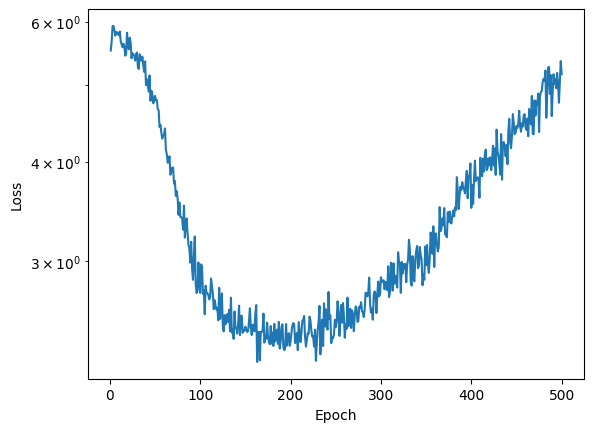

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

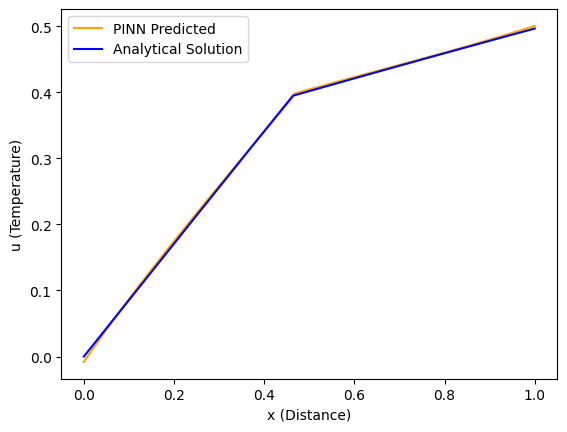

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*4
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

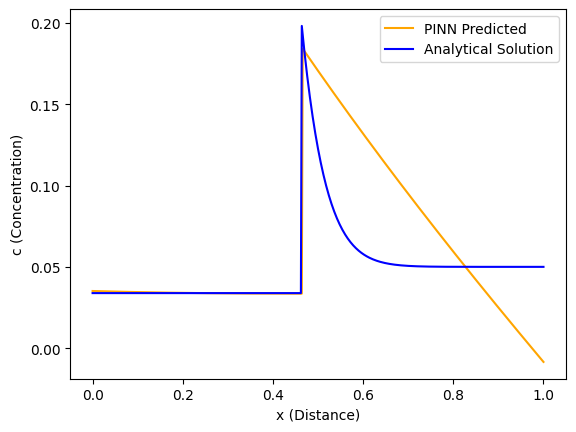

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
umodel.save('/content/drive/MyDrive/Shivprasad/umodel_aw')
cmodel.save('/content/drive/MyDrive/Shivprasad/cmodel_aw')

In [ ]:
# learning_rate = 0.0001 and new:old coeff = 0.3:0.7
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps[0:12]) + lamb1*loss_comps[-2] + lamb2*loss_comps[-1]
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.5311076, 0.63866687, 3.176572, 0.003684816, 5.413034e-06, 0.0004542652, 0.047220457, 0.3151063, 0.12301194, 3.1256448e-05, 0.32669994, 3.314669e-05, 0.066512614, 0.04516551]
[0.2275303, 0.46878892, 4.246164, 0.005175682, 5.413034e-06, 0.0004214099, 0.5700854, 0.325263, 0.10999784, 6.070742e-06, 0.381434, 2.3597007e-05, 0.005957709, 0.038943008]
[0.19863355, 0.5098276, 4.1455727, 0.008840479, 5.413034e-06, 0.00010241842, 0.6460927, 0.3874515, 0.16021255, 7.814829e-06, 0.36794698, 2.5305728e-05, 0.004840855, 0.032764032]
[0.17465346, 0.49229896, 4.1366224, 0.010269084, 5.413034e-06, 0.000108930304, 0.6383028, 0.48144838, 0.21595313, 8.814014e-06, 0.36150962, 2.5421286e-05, 0.0043319236, 0.032191675]
[0.20042504, 0.5285021, 4.122015, 0.010798315, 5.413034e-06, 4.6278517e-05, 0.61955225, 0.5837609, 0.25916982, 9.408878e-06, 0.3573089, 2.5825131e-05, 0.0040371413, 0.03212977]
[0.15195093, 0.47104725, 4.130517, 0.011397679, 5.413034e-06, 0.00012705255, 0.60034364, 0.7089079, 0.28090987, 1

Text(0, 0.5, 'Loss')

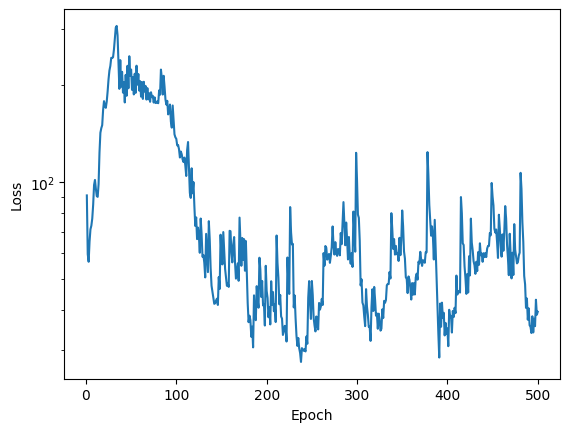

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

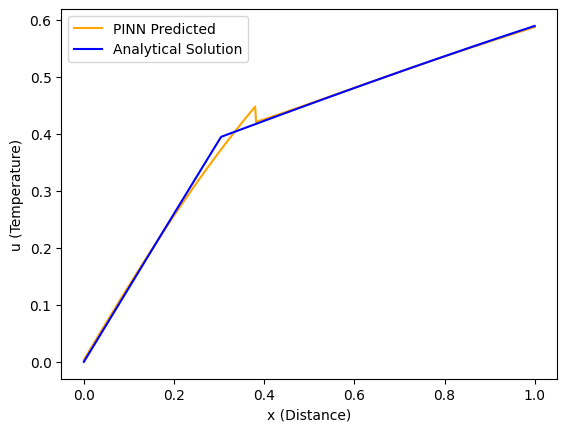

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

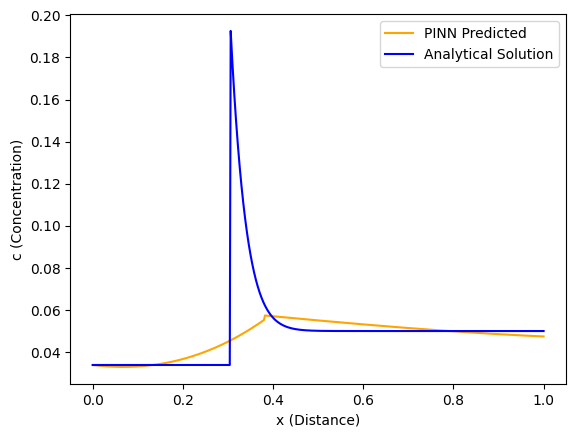

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
# learning_rate = 0.000001 and new:old coeff = 0.3:0.7
from time import time
N = 200 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps[0:12]) + lamb1*loss_comps[-2] + lamb2*loss_comps[-1]
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.48237696, 0.5788109, 3.1862354, 0.0036981446, 5.413034e-06, 0.0004591001, 0.047124233, 0.316372, 0.12419103, 3.2212047e-05, 0.33185464, 3.334285e-05, 0.066512614, 0.04516551]
[0.48708007, 0.7764684, 3.1642842, 0.0035362705, 0.0010740218, 0.0009856679, 0.042447865, 0.31630683, 0.14323631, 3.2276894e-05, 0.3866828, 3.3119923e-05, 0.05806332, 0.04636451]
[0.36384284, 0.84223574, 3.0997958, 0.0032924027, 0.0010603529, 0.0010372075, 0.035641816, 0.32057187, 0.10128161, 3.077846e-05, 0.47330812, 3.5395475e-05, 0.05181621, 0.04834065]
Final Loss = 81.85237
Computation Time = 6.251017562548319 minutes


Text(0, 0.5, 'u (Temperature)')

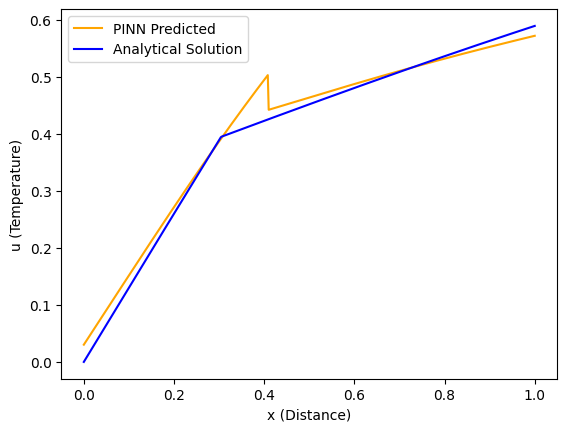

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

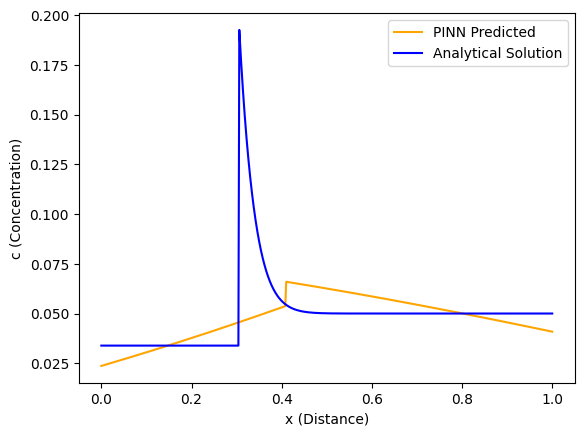

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
# learning_rate = 0.000001
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 0.1, 0.1
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps[0:12]) + lamb1*loss_comps[-2] + lamb2*loss_comps[-1]
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.5643035, 0.6730748, 3.158287, 0.0036424403, 5.413034e-06, 0.0004383056, 0.047539435, 0.31161845, 0.14168781, 3.1393985e-05, 0.32206625, 3.30808e-05, 0.066512614, 0.04516551]
[0.27752462, 0.5985197, 3.392197, 0.0035760028, 0.0011679251, 0.0011044623, 0.034584336, 0.31593394, 0.12195845, 3.1849224e-05, 0.39422518, 3.3778953e-05, 0.023974098, 0.04631202]
[0.23326506, 0.6707369, 3.3604298, 0.0032286865, 0.0012062239, 0.0009980962, 0.056301516, 0.3069244, 0.11001271, 2.9778683e-05, 0.45168144, 3.402946e-05, 0.019613635, 0.048283555]
[0.27969772, 0.7445316, 3.331466, 0.0030907854, 0.0011212898, 0.00086211093, 0.098405264, 0.3037036, 0.11979846, 2.923845e-05, 0.56975836, 3.6826164e-05, 0.02220481, 0.05041697]
[0.25828612, 0.7802668, 3.2642746, 0.0029435332, 0.0010368348, 0.000796972, 0.14339815, 0.2983166, 0.11348451, 2.8906166e-05, 0.6527237, 3.7940605e-05, 0.022259928, 0.051383976]
[0.23043193, 0.76487553, 3.2216861, 0.0027784794, 0.0009589318, 0.00071795314, 0.1809537, 0.30502746, 0.121

In [ ]:
lamb1, lamb2

(<tf.Tensor: shape=(), dtype=float32, numpy=1519.5514>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1296.946>)

Text(0, 0.5, 'Loss')

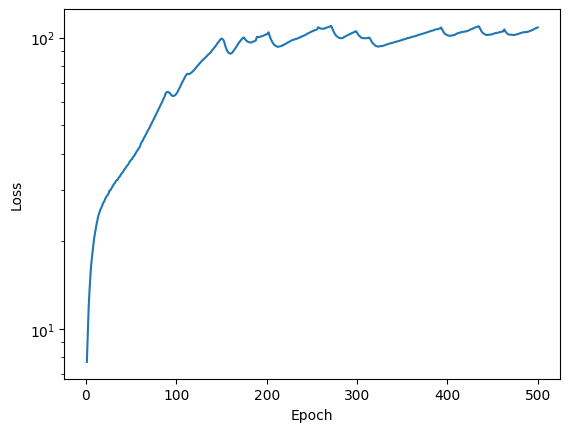

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

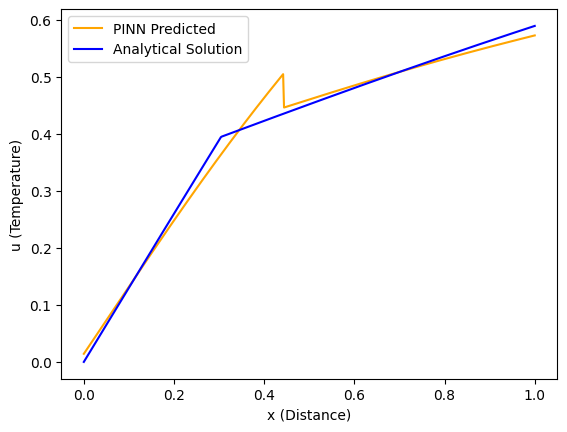

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.44355595, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

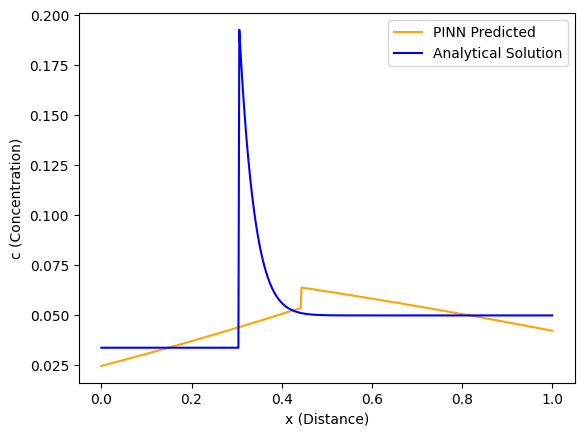

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
# learning_rate = 0.00001
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 0.1, 0.1
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%100 == 0:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps[0:12]) + lamb1*loss_comps[-2] + lamb2*loss_comps[-1]
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.23991543, 0.8502228, 3.0830128, 0.0024788608, 0.0007895438, 0.0010113404, 0.31225228, 0.31906715, 0.080330946, 2.8489863e-05, 1.0966965, 4.395641e-05, 0.027972938, 0.052959975]
[0.2585617, 0.44716597, 3.6427233, 0.0023980164, 0.00079148775, 0.0011821745, 0.5174402, 0.48585328, 0.054312006, 1.209037e-05, 1.3558288, 3.652511e-05, 0.023909302, 0.052662473]
[0.20851548, 0.35078043, 3.9125445, 0.0023806633, 0.0007905155, 0.0006225092, 0.59780174, 0.68459487, 0.05230509, 4.1396074e-06, 1.3885274, 3.3884608e-05, 0.019010546, 0.05296966]
[0.20258398, 0.4322206, 3.9662964, 0.002469672, 0.00078136683, 0.00032341137, 0.6447664, 0.7783572, 0.07029756, 2.38983e-06, 1.3881063, 3.4319633e-05, 0.014466578, 0.052055284]
[0.1764927, 0.4499189, 4.0928016, 0.0025079495, 0.00069762184, 6.141921e-05, 0.65902245, 0.8410489, 0.10619863, 6.50644e-07, 1.3467069, 3.3742268e-05, 0.012282911, 0.0519947]
Final Loss = 4635.195
Computation Time = 15.758156804243724 minutes


Text(0, 0.5, 'Loss')

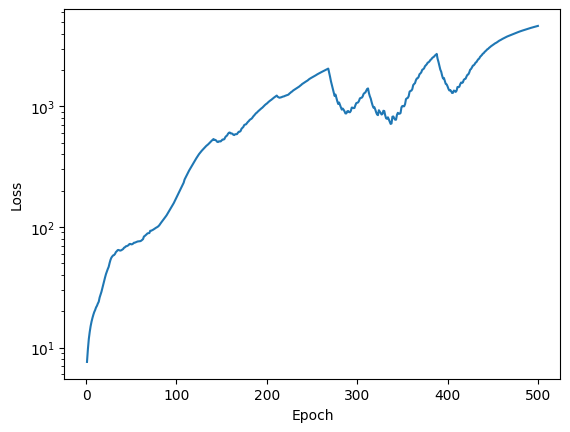

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

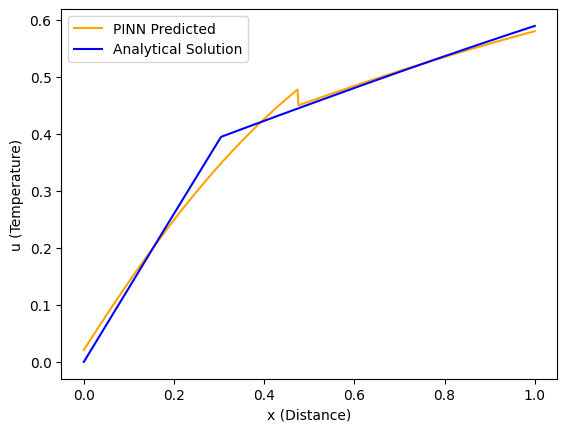

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.47572896, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

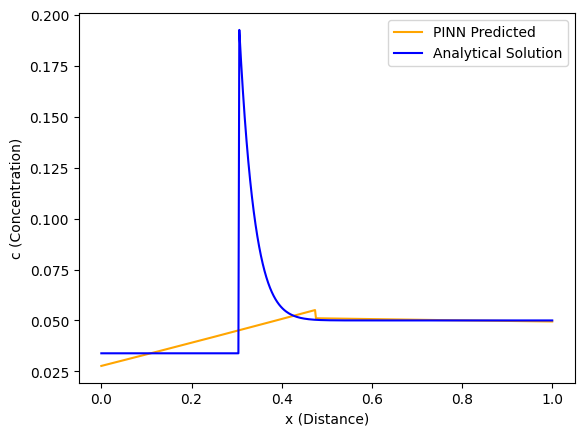

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, mea, um, cm, coll): # compute gradient of loss wrt model weights  # additional parameter theta
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    #tape.watch(theta)
    losses = loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights) # additional parameter theta
    #Lhr = losses[9] + losses[10]
    #Lhd = losses[7]
    loss = sum(losses)# - (1-lamb)*Lhd
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  #gr = tape.gradient(Lhr, umodel.trainable_variables)
  #gd = tape.gradient(Lhd, umodel.trainable_variables)
  #print(gd[0].shape), print(gr[0].shape) # list of tensor gradients
  #gt = tape.gradient(loss, theta)
  del tape
  return losses, gu, gs, gc#, gr, gd#, gt

In [ ]:
def train_step(coll):
  # compute loss and its gradient wrt model parameters
  losses, gu, gs, gc = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, coll)
  #fgd = tf.concat([tf.reshape(g,[-1]) for g in gd if g is not None],axis=-1)
  #denom = tf.reduce_mean(tf.math.abs(lamb*fgd))
  #fgr = tf.concat([tf.reshape(g,[-1]) for g in gr if g is not None],axis=-1)
  #numer = tf.reduce_max(tf.math.abs(fgr))
  #new_lamb = numer/denom
  #new_lamb = 0.1*new_lamb + 0.9*lamb
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  #optim2.apply_gradients([(gt, theta)])
  return losses#, new_lamb

In [ ]:
#LR=0.00001 and weighted losses
from time import time
N = 250 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps = train_step(coll)
  if i%50 == 0 or i==1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 50 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.5661701, 0.6779317, 3.1844532, 0.0036056663, 5.413034e-06, 0.0004474773, 0.04739465, 0.3132921, 0.14553362, 3.2709224e-05, 0.33153352, 3.338133e-05, 0.066512614, 0.04516551]
[0.295277, 0.53766036, 2.1278458, 0.0028254436, 0.0013519584, 0.008558969, 0.016428955, 0.36122066, 0.12915541, 3.8257862e-05, 0.31052765, 4.4603465e-05, 0.108752556, 0.06188858]
[0.29415423, 0.42564034, 1.3083215, 0.0025279915, 0.001243658, 0.03358194, 0.028402854, 0.34485292, 0.11632761, 5.1541112e-05, 0.31685197, 5.952588e-05, 0.21069758, 0.09735046]
[0.2906216, 0.34087026, 0.85440195, 0.0024040302, 0.0012005067, 0.06543846, 0.024492718, 0.30042773, 0.093105406, 6.759254e-05, 0.29992008, 7.327555e-05, 0.22362952, 0.14092784]
[0.39572173, 0.39193195, 0.6377533, 0.0023062073, 0.0011955296, 0.092867054, 0.024593191, 0.25301835, 0.12763873, 9.347889e-05, 0.29356465, 8.880414e-05, 0.19274813, 0.19047348]
[0.33227235, 0.30764505, 0.48731485, 0.0022481421, 0.0010919796, 0.10720564, 0.02470873, 0.21345004, 0.1337867,

Text(0, 0.5, 'Loss')

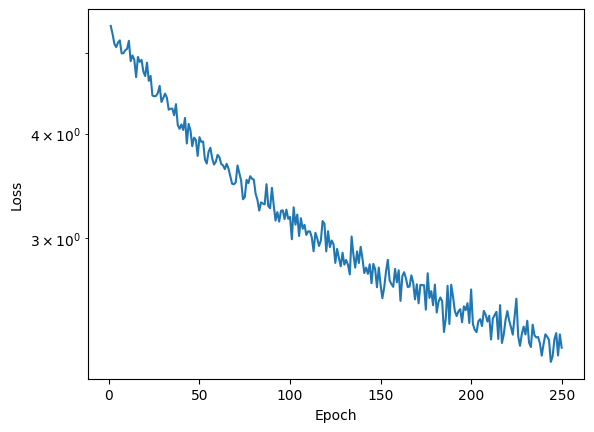

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

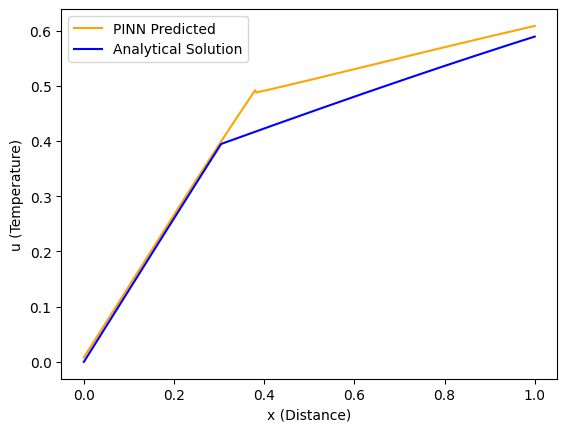

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.3805047, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

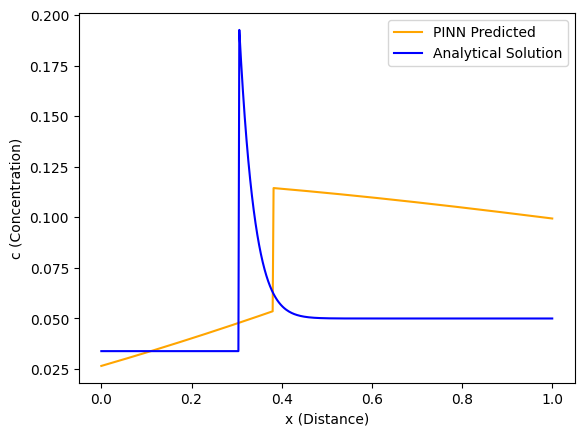

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
#LR=0.001
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps = train_step(coll)
  if i%100 == 0 or i==1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.0022043106, 0.0026291984, 0.012337059, 0.0036424403, 2.1144664e-10, 4.383056e-06, 0.00047539434, 0.31161845, 0.14168781, 3.1393985e-05, 0.32206625, 3.30808e-05, 0.0005196298, 0.00035285554]
[0.003601014, 0.002114531, 0.0017119275, 1.1182961e-05, 0.00047324627, 0.00032131333, 0.001279617, 0.00040432505, 0.0006514392, 0.00077950733, 2.385687e-05, 4.915769e-05, 0.0014030173, 0.003683281]
[0.0021254949, 0.0019085347, 0.00360555, 0.000107441476, 0.0005853512, 0.00055864954, 0.0013957474, 0.000113436436, 0.0004604518, 0.00020566533, 0.00011418909, 7.360519e-05, 0.0030985705, 0.0026431668]
[0.0019662213, 0.0016354759, 0.0017502203, 0.0001893368, 0.00017843054, 0.00043967852, 0.0010579543, 5.3919815e-05, 0.0002569713, 0.00013821293, 0.00026451473, 0.0004256691, 0.002651094, 0.0006866555]
[0.0014920546, 0.0013658962, 0.000333036, 7.979619e-06, 0.0001731102, 0.00032650665, 0.00073328253, 1.8079669e-05, 0.00011866727, 0.000109904744, 6.170231e-05, 0.00040830375, 0.0025571273, 0.0005614771]
[0.

Text(0, 0.5, 'Loss')

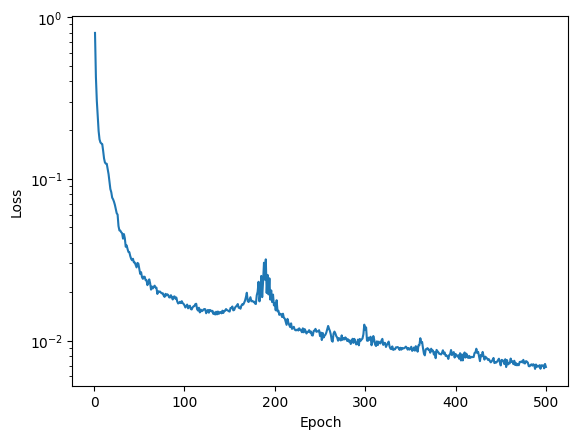

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(-0.11455072, 0.3044444)

In [ ]:
#LR=0.00001
from time import time
N = 250 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps = train_step(coll)
  if i%50 == 0 or i==1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 50 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.001884285, 0.00226098, 0.012446232, 0.0036981446, 2.1144664e-10, 4.591001e-06, 0.00047124233, 0.316372, 0.12419103, 3.2212047e-05, 0.33185464, 3.334285e-05, 0.0005196298, 0.00035285554]
[0.0025671807, 0.0026460018, 0.014479989, 0.0021649215, 8.7872996e-07, 6.5706285e-05, 0.0014566656, 0.21079475, 0.12639797, 3.9108123e-05, 0.12675047, 3.138792e-05, 0.0003950144, 0.0003866332]
[0.0053427233, 0.0062199165, 0.0138558075, 0.0012772619, 1.5494684e-06, 0.0002565966, 0.0026625963, 0.13807009, 0.10429971, 5.7734953e-05, 0.053905908, 3.2228167e-05, 0.0008168308, 0.00073262723]
[0.007506002, 0.008758802, 0.012386095, 0.00087466795, 7.698968e-07, 0.00046410374, 0.0037800628, 0.09518635, 0.091705956, 9.0701535e-05, 0.029237647, 3.543083e-05, 0.0011561214, 0.0014581499]
[0.008008066, 0.009813495, 0.0105662765, 0.000657332, 1.9401446e-08, 0.0005986771, 0.0045450306, 0.06869657, 0.045271352, 0.00013447355, 0.01525708, 3.7455142e-05, 0.0013761836, 0.0024668535]
[0.008329153, 0.010251681, 0.00904392

Text(0, 0.5, 'Loss')

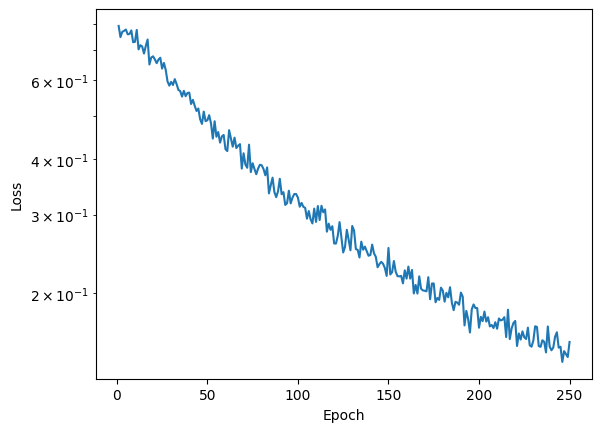

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

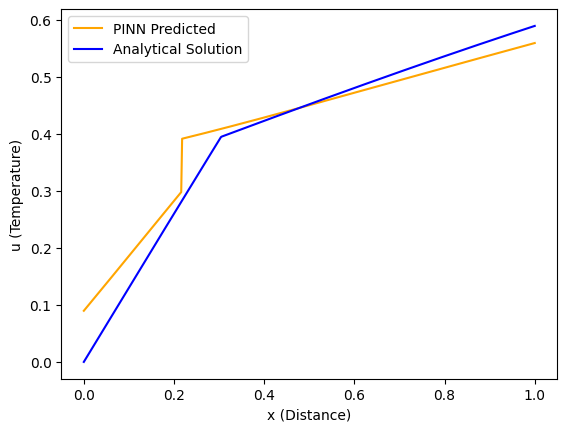

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.21604422, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

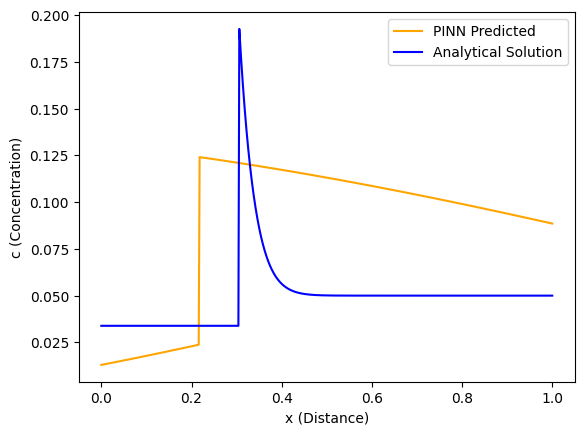

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

In [ ]:
#LR=0.01
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 500 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps = train_step(coll)
  if i%100 == 0 or i==1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.0022043106, 0.0026291984, 0.012337059, 0.0036424403, 2.1144664e-10, 4.383056e-06, 0.00047539434, 0.31161845, 0.14168781, 3.1393985e-05, 0.32206625, 3.30808e-05, 0.0005196298, 0.00035285554]
[0.002043084, 0.00200685, 0.00052839715, 4.27787e-05, 0.0002811841, 0.00042394485, 0.0017740517, 0.000103721955, 0.0004103012, 0.00012878263, 0.0001936697, 0.00022622649, 0.0027045573, 0.00078127696]
[0.0010892903, 0.0012964773, 0.00017101734, 7.895878e-06, 0.00019757786, 0.0001387659, 0.00076299085, 2.8902718e-05, 0.00018771974, 0.00021266022, 7.405205e-05, 0.00016192297, 0.0025323078, 0.0005070167]
[0.22502935, 3.5611937, 2.375895, 4.344435, 2.6980252, 45.614746, 0.6159116, 0.040306438, 0.76381207, 2.0570862, 16.16938, 0.05436302, 0.5408314, 5.3792753]
[2.2089882, 1.7598394, 0.10585017, 383.48846, 18440.215, 0.015335418, 0.029252283, 0.058174007, 0.041331653, 0.0028664193, 179617.92, 1.9623427, 3.1983585, 372.50772]
[0.09998251, 1.3281674, 0.08730463, 0.03631736, 3952.9456, 0.00022936192, 0.041

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps = train_step(coll)
  if i%1000 == 0:
      print([num.numpy() for num in loss_comps]) # recording loss components every 1000 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.0007991302, 0.0008207775, 7.556188e-05, 7.429074e-06, 0.00013074967, 9.3401184e-05, 0.00044178887, 1.9675095e-05, 5.910713e-05, 0.00012456889, 1.52352395e-05, 0.000307798, 0.0024006611, 0.0005216049]
[0.00059668045, 0.0005888243, 6.41495e-05, 5.101812e-06, 0.00011594481, 4.7629033e-05, 0.00034705145, 1.5062133e-05, 4.8942067e-05, 0.00014321244, 1.9506528e-05, 0.00025785685, 0.002328195, 0.00048046705]
[0.00046786488, 0.00046386977, 6.6270986e-05, 3.8202274e-06, 9.573704e-05, 3.616594e-05, 0.00020321098, 3.1824817e-05, 7.67129e-05, 0.00012365739, 2.3824612e-05, 0.00022633187, 0.0021512196, 0.0004385974]
[0.00044415751, 0.00047593168, 8.1235376e-05, 5.403961e-06, 7.091832e-05, 3.2357188e-05, 0.0001114918, 6.256986e-05, 8.0286954e-05, 8.871075e-05, 3.509365e-05, 0.00016681648, 0.0018353469, 0.00038199328]
[0.00029156837, 0.00028635832, 5.401135e-05, 4.1865433e-06, 6.200659e-05, 1.4535791e-05, 9.3629686e-05, 7.618745e-05, 8.180244e-05, 6.0248123e-05, 1.869656e-05, 0.00011646824, 0.00182

Text(0, 0.5, 'Loss')

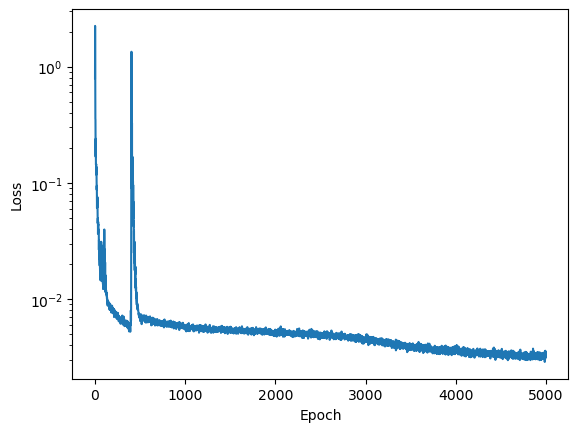

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(-0.2221622, 0.3044444)

Text(0.5, 1.0, 'Predicted vs Actual Movement of Interface')

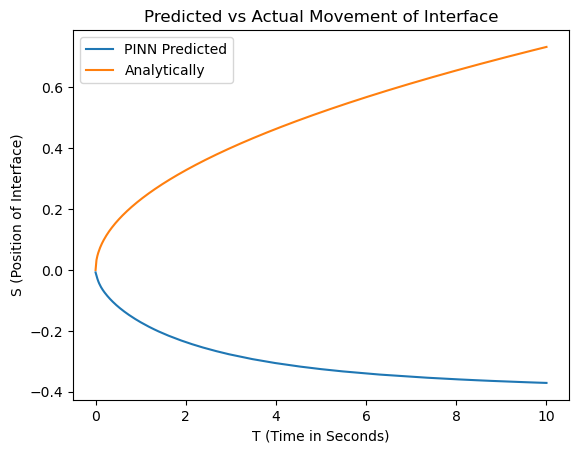

In [ ]:
t_values = tf.cast(tspace,DTYPE)
s_values = smodel(t_values)
s_exact = s_anal(t_values)
plt.plot(t_values,s_values)
plt.plot(t_values,s_exact)
plt.legend(['PINN Predicted','Analytically'])
plt.xlabel('T (Time in Seconds)')
plt.ylabel('S (Position of Interface)')
plt.title('Predicted vs Actual Movement of Interface')

###Earlier

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, mea, um, cm, coll, lamb1, lamb2, lamb3): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lur = losses[7] + losses[8]
    Lcr = losses[9] + losses[3]
    Lud = losses[-2]
    Lcd = losses[-1]
    Lub = losses[0] + losses[1]
    loss = sum(losses[2:12]) + lamb1*Lud + lamb2*Lcd + lamb3*Lub
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gub = tape.gradient(Lub, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gu, gs, gc, gur, gud, gub, gcr, gcd

In [ ]:
Nc = 10000 # No of collocation points
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
cmodel = c_model() # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,2000,3000,4000],[5e-3,1e-3,5e-4,1e-4,5e-5]) # decreasing learning rate which is piecewise constant
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr) # Adam Optimiser

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 0.1, 0.1
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%1000 == 0:
      print([num.numpy() for num in loss_comps]) # recording loss components every 1000 epochs
  loss = sum(loss_comps[0:12]) + lamb1*loss_comps[-2] + lamb2*loss_comps[-1]
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.018545585, 0.010147646, 0.0018644237, 3.6924866e-05, 0.0005143813, 0.0003615145, 0.00798756, 0.70840836, 1.8633168, 0.00011289456, 0.00052044354, 0.0007220347, 5.5082575e-05, 0.0005724726]
[0.0030681107, 0.0077500762, 0.005558725, 0.00015639354, 8.099421e-05, 1.7259758e-06, 0.0067787804, 0.11519992, 2.1904204, 0.020424737, 0.0009326799, 0.00075685757, 2.8671224e-05, 6.8435106e-06]
[0.004714514, 9.8563505e-05, 0.065843895, 0.00085195084, 0.019329986, 7.043407e-05, 0.006758232, 1.599351, 3.4777055, 0.020987375, 0.002522231, 2.6641356e-07, 4.292398e-06, 4.6984223e-06]
[0.0062660486, 0.001604052, 0.021324571, 0.00092481595, 0.0032319443, 2.19677e-05, 0.006929142, 1.0794892, 2.8173265, 0.024672898, 0.020090878, 0.00072860566, 7.957714e-06, 1.2163708e-05]
[0.0044043944, 0.005635516, 0.008216085, 0.0004013895, 1.8325433e-06, 1.9391093e-05, 0.007924854, 0.91195565, 3.5469594, 0.042936478, 0.006906753, 0.0011345621, 2.0805846e-06, 9.3679716e-07]
Final Loss = 104.67288
Computation Time = 133.

In [ ]:
lamb1, lamb2

(<tf.Tensor: shape=(), dtype=float32, numpy=46978240.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2555705.0>)

Text(0, 0.5, 'Loss')

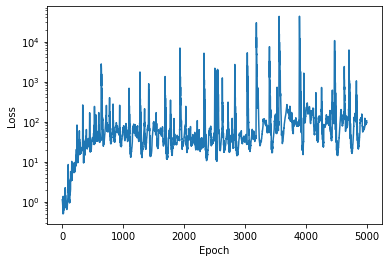

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

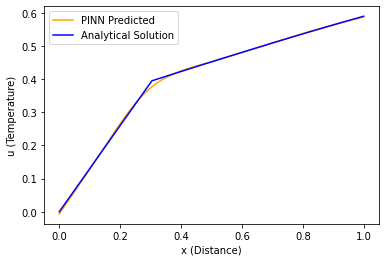

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(-0.14014997, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

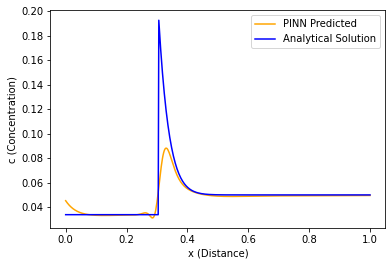

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

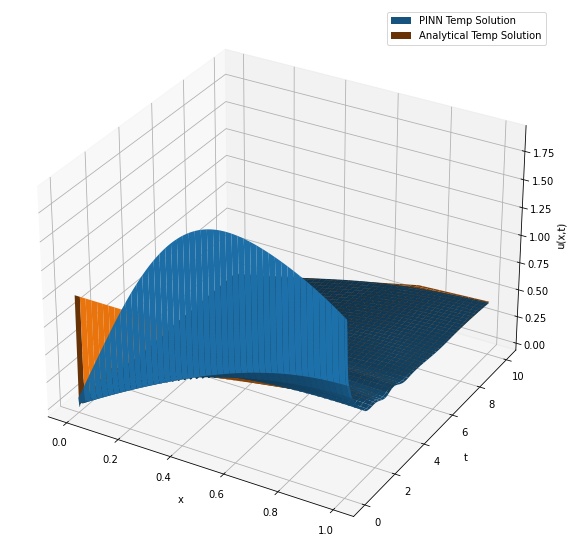

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = umodel(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

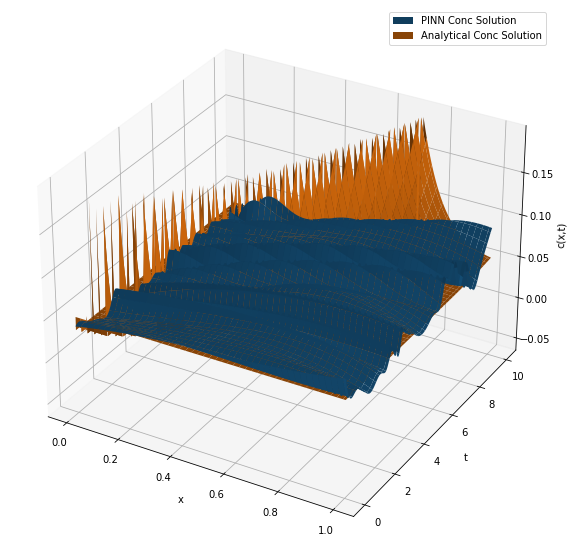

In [ ]:
c_pred = cmodel(input)
c1_p, c2_p = c_pred[:, 0:1], c_pred[:, 1:2]
cp = tf.where(tf.math.greater(s_pred,x_inp), c1_p, c2_p)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

Text(0.5, 1.0, 'Predicted vs Actual Movement of Interface')

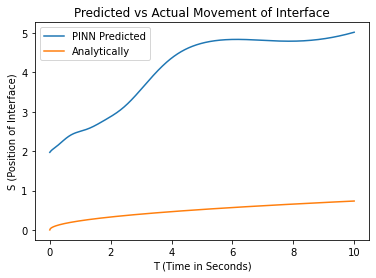

In [ ]:
t_values = tf.cast(tspace,DTYPE)
s_values = smodel(t_values)
s_exact = s_anal(t_values)
plt.plot(t_values,s_values)
plt.plot(t_values,s_exact)
plt.legend(['PINN Predicted','Analytically'])
plt.xlabel('T (Time in Seconds)')
plt.ylabel('S (Position of Interface)')
plt.title('Predicted vs Actual Movement of Interface')